# Features comparison

In [81]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()
import scipy
from scipy import stats
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [83]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'AAPL'
price_column = 'Close'

predict_n = 1
NORMALIZE_FEATURES = True

In [84]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=NORMALIZE_FEATURES)

data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.001741,0.001969,0.002107,0.002934,0.337769,0.002524,0.000078,0.597417,0.000317,...,0.000023,0.000000,0.000000,0.445527,0.531663,0.516652,0.683788,higher,0.003017,higher
1,2007-02-22,0.003014,0.002316,0.002805,0.003017,0.243081,0.002595,0.003813,0.608719,0.006346,...,0.000117,0.000040,0.000135,0.445232,0.531187,0.511465,0.573995,higher,0.002899,lower
2,2007-02-23,0.002581,0.002192,0.002891,0.002899,0.147424,0.002494,0.000856,0.582323,0.001388,...,0.000197,0.000081,0.000236,0.443849,0.530828,0.510164,0.547628,lower,0.002750,lower
3,2007-02-26,0.002760,0.002103,0.002555,0.002750,0.176675,0.002365,0.003501,0.548723,0.003054,...,0.000343,0.000126,0.000302,0.442470,0.529935,0.509956,0.543318,lower,0.001528,lower
4,2007-02-27,0.001825,0.001335,0.001414,0.001528,0.334932,0.001315,0.002023,0.340556,0.008765,...,0.000317,0.000097,0.000187,0.435232,0.529921,0.502983,0.400476,lower,0.001710,higher


In [85]:
feature_names = data_wrapper.feature_names

In [86]:
def compute_t_test_classes(df, feature_names, classes, class_column='Next', equal_var=False):
    feature_p_vals = {}
    for feature in feature_names:
        # get the filtered series with only the feature, filtered by the target class
        a = df[df[class_column] == classes[0]][feature]
        b = df[df[class_column] == classes[1]][feature]


        t_stat, p_computed = stats.ttest_ind(a, b, equal_var = equal_var)
        feature_p_vals[feature] = p_computed
            
    # return the dictionary sorted by p_value (ASC)
    return {k: v if not np.isnan(v) else 1.0 for k, v in sorted(feature_p_vals.items(), key=lambda item: item[1])}

classes = list(data_wrapper['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume', 'Close']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']] 

feature_p_vals = compute_t_test_classes(data_wrapper.df, test_feature_names, classes)

In [87]:
print("Feature p-values (lower is better):\n")
for feature, val in feature_p_vals.items():
    print(f"[{feature}] -> {100*val:.2f} %")

Feature p-values (lower is better):

[Difference] -> 0.57 %
[LowLen] -> 2.98 %
[PercentageDiff] -> 4.28 %
[RSI(14)] -> 4.93 %
[StochOsc] -> 11.95 %
[MACD] -> 14.95 %
[RSI_diff] -> 16.95 %
[MACD_signal] -> 17.43 %
[SMA(20) - SMA(10)] -> 20.73 %
[BG_H_Band_Indicator] -> 23.86 %
[GAP] -> 24.24 %
[ROC] -> 24.30 %
[Volume_diff] -> 25.81 %
[NextPrice] -> 39.21 %
[MACD_diff] -> 56.37 %
[Volume] -> 56.59 %
[BG_L_Band_Indicator] -> 71.56 %
[EMA_Diff] -> 89.35 %
[BG_H_Band] -> 90.99 %
[SMA(20)] -> 92.73 %
[BodyLen] -> 94.51 %
[BG_L_Band] -> 94.78 %
[EMA(14)] -> 95.38 %
[Close] -> 96.03 %
[SMA(10)] -> 96.81 %


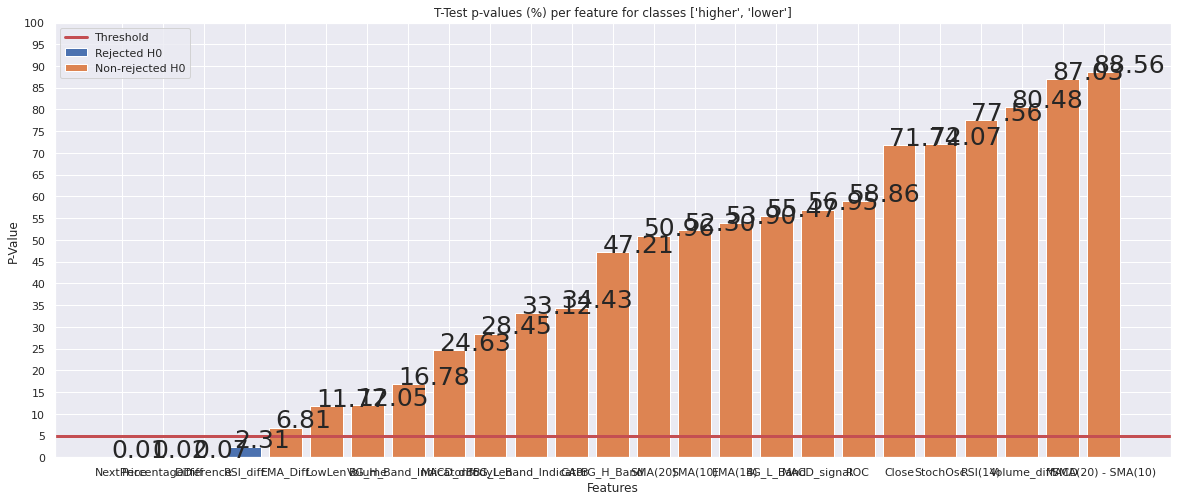

In [100]:
P_THRESH = 0.05


lowers = [(label, val) for label, val in feature_p_vals.items() if val <= P_THRESH]
highers = [(label, val) for label, val in feature_p_vals.items() if val > P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x*100 for x in feature_p_vals.values()]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.show()

In [101]:
df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES, predict_n=predict_n)

higher_features_dict = {k:0 for k,v in feature_p_vals.items()}
lower_features_dict = {k:0 for k,v in feature_p_vals.items()}

# for each dataset given count the times where the features was higher or lower than the threshold
for (label, dataset) in tqdm(df_dict.items()):
    df = dataset.df
    feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
    for k,v in feature_p_vals.items():
        try:
            if v > P_THRESH:
                higher_features_dict[k] += 1
            else:
                lower_features_dict[k] += 1
        except KeyError as e:
            print(f"Some key was filtered from the dict")

  0%|          | 0/14 [00:00<?, ?it/s]

In [102]:
df = pd.DataFrame(list(lower_features_dict.items()), columns=['Feature','Lower'])
# add the sum for the plot
df['Lower_Ratio'] = df['Lower'].apply(lambda x: float(x) / len(df_dict))
df['Sum'] = pd.Series(1.0 for val in zip(higher_features_dict.values(), lower_features_dict.values()))
df = df.sort_values(by='Lower', ascending=False)
df.loc[:, ['Feature', 'Lower_Ratio']]

,Feature,Lower_Ratio
0,NextPrice,0.642857
5,LowLen,0.357143
11,GAP,0.285714
19,Close,0.285714
16,BG_L_Band,0.285714
15,EMA(14),0.285714
14,SMA(10),0.285714
13,SMA(20),0.285714
12,BG_H_Band,0.285714
9,BodyLen,0.214286


In [103]:
#df.to_csv('features_comparison.csv', index=False)

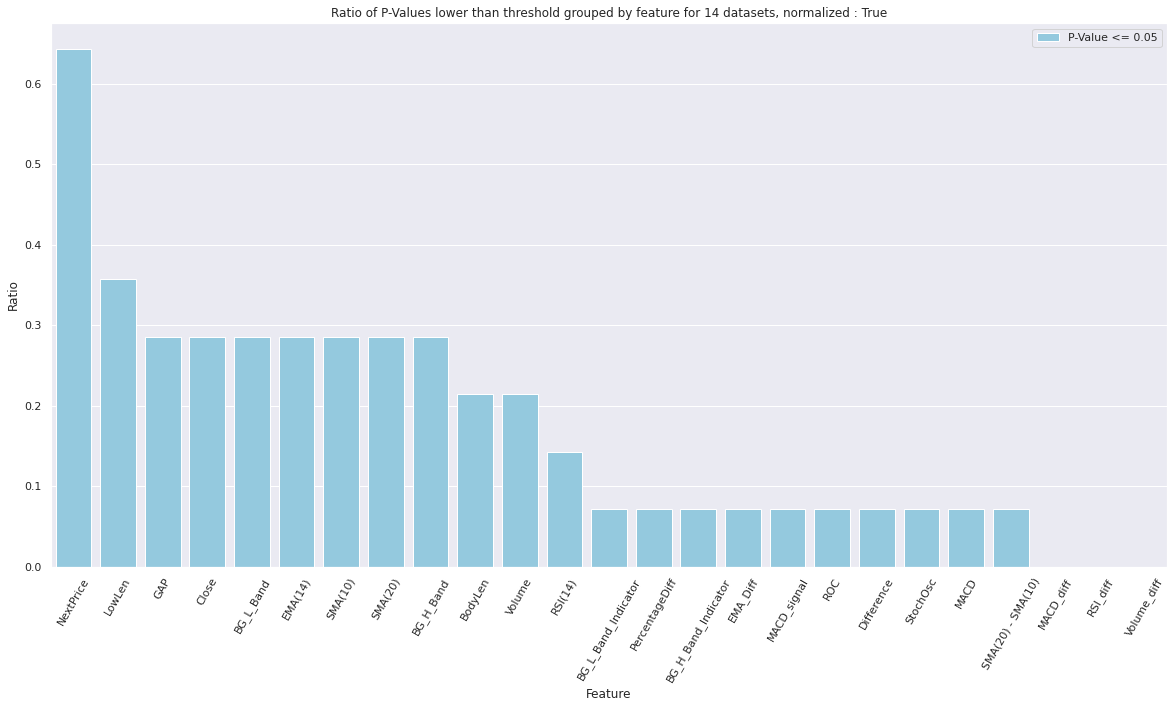

In [104]:
plt.figure(figsize=(20,10))
matplotlib.rcParams.update({'font.size': 22})
bar_lower = sns.barplot(x='Feature', y='Lower_Ratio', estimator=sum, data=df, color="skyblue", label=f"P-Value <= {P_THRESH}")
bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
plt.title(f"Ratio of P-Values lower than threshold grouped by feature for {len(df_dict)} datasets, normalized : {NORMALIZE_FEATURES}")
plt.legend(loc='best')
plt.ylabel('Ratio')
plt.show()

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

data_columns = ['Close', 'Volume', 'LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 
                'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 
                'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='Next', 
                                                             features_list=data_columns)


In [95]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVC

In [97]:
test_predicts = [1, 5, 10, 20, 50]
n_features=8

df_features_dict = {}

for predict_n in test_predicts:
    rfe_features = {k:0 for k in data_columns}
    sfs_features = {k:0 for k in data_columns}
    
    df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES, predict_n=predict_n)

    for (label, data_wrapper) in tqdm(df_dict.items()):
        X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='Next', 
                                                             features_list=data_columns)

        svc = SVC(kernel="linear", gamma='scale', C=10.0)
        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(estimator=svc, step=1, cv=tscv.split(X_train),
                      scoring='accuracy', verbose=1,
                      min_features_to_select=min_features_to_select, n_jobs=-1)
        sfs = SequentialFeatureSelector(svc, n_features_to_select=n_features, cv=5, n_jobs=-1)
        rfecv.fit(X_train, y_train)
        sfs.fit(X_train, y_train)


        for i, col in enumerate(data_columns):
            #print(f"[{col}] : selected : {rfecv.support_[i]}, rank : {rfecv.ranking_[i]}")


            if rfecv.support_[i] == True:
                #print(f"True for {col}")
                rfe_features[col] += 1
            if sfs.support_[i] == True:
                sfs_features[col] += 1
                
        

    df = pd.DataFrame(list(rfe_features.items()), columns=['Feature','RFE'])
    df['SFS'] = sfs_features.values()
    df['RFE_Ratio'] = df['RFE'].apply(lambda x: float(x) / len(df_dict))
    df['SFS_Ratio'] = df['SFS'].apply(lambda x: float(x) / len(df_dict))
    df = df.sort_values(by='RFE_Ratio', ascending=False)
    df.loc[:, ['Feature', 'RFE_Ratio', 'SFS_Ratio']]
    df_features_dict[predict_n] = df.copy()
    print(f"N_days predict : {predict_n}, results : \n{df}")

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 feature

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 feature

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 featu

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.

  0%|          | 0/14 [00:00<?, ?it/s]

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 featur

In [98]:
for predict_n, df in df_features_dict.items():
    df.to_csv(f"{predict_n}_features_comparison.csv", index=False)

In [128]:
plt.figure(figsize=(20,10))

for predict_n, df in df_features_dict.items():
    bar_lower = sns.barplot(x='Feature', y='RFE_Ratio', estimator=sum, data=df, color="skyblue", label=f"Ratio of feature selection")
    bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
    plt.title(f"[RFE] Ratio of feature selection for {len(df_dict)} datasets, predicting for {predict_n} day(s) later")
    plt.legend(loc='best')
    plt.ylabel('Ratio', fontsize=18)
    plt.xlabel('Feature', fontsize=18)
    plt.xticks(fontsize=18, rotation=60)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"plots/RFE_Feature_Selection_{predict_n}.png")
    plt.close()
    
for predict_n, df in df_features_dict.items():
    df = df.sort_values(by='SFS_Ratio', ascending=False)
    bar_lower = sns.barplot(x='Feature', y='SFS_Ratio', estimator=sum, data=df, color="skyblue", label=f"Ratio of feature selection")
    bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
    plt.title(f"[SFS] Ratio of feature selection for {len(df_dict)} datasets, predicting for {predict_n} day(s) later")
    plt.legend(loc='best')
    plt.xticks(fontsize=18, rotation=60)
    plt.yticks(fontsize=18)
    plt.ylabel('Ratio', fontsize=18)
    plt.xlabel('Feature', fontsize=18)
    plt.tight_layout()
    plt.savefig(f"plots/SFS_Feature_Selection_{predict_n}.png")
    plt.close()

### PCA

In [80]:
from sklearn.decomposition import PCA



test_predicts = [1, 5, 10, 20, 50]
test_predicts = [1]
pca_dict = {}

for predict_n in test_predicts:
    stocks_pca_dict = {}
    rfe_features = {k:0 for k in data_columns}
    sfs_features = {k:0 for k in data_columns}
    
    df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES, predict_n=predict_n)

    for (label, data_wrapper) in tqdm(df_dict.items()):
        X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='Next', 
                                                             features_list=data_columns)
        pca = PCA()
        pca.fit_transform(X_train)
        
        for component, ratio in zip(pca.components_, pca.explained_variance_ratio_):
            print(f"[VAR={ratio}]\n\t")
            feature_var_dict = {}
            for val, col in zip(component, data_columns):
                feature_var_dict[col] = val
                feature_var_dict = {k: v for k, v in sorted(feature_var_dict.items(), key=lambda item: item[1], reverse=True)}
            for col, val in feature_var_dict.items():
                print(f"{val:.2f} * {col} + ", end='')
            
            print("\n\n")
        break

  0%|          | 0/14 [00:00<?, ?it/s]

[VAR=0.613278738091747]
	
0.41 * SMA(20) + 0.41 * EMA(14) + 0.41 * BG_L_Band + 0.41 * SMA(10) + 0.40 * BG_H_Band + 0.40 * Close + 0.05 * LowLen + 0.05 * BodyLen + 0.03 * GAP + 0.02 * MACD_signal + 0.01 * MACD + 0.01 * StochOsc + 0.01 * RSI(14) + 0.01 * BG_L_Band_Indicator + 0.00 * Volume + 0.00 * Volume_diff + -0.00 * EMA_Diff + -0.00 * Difference + -0.00 * PercentageDiff + -0.00 * RSI_diff + -0.00 * SMA(20) - SMA(10) + -0.01 * ROC + -0.01 * MACD_diff + -0.01 * BG_H_Band_Indicator + 2.5917027896503693



[VAR=0.19117741327246443]
	
0.23 * BG_L_Band_Indicator + 0.16 * SMA(20) - SMA(10) + 0.03 * BG_H_Band + 0.02 * BodyLen + 0.02 * SMA(20) + 0.02 * BG_L_Band + 0.02 * LowLen + 0.00 * GAP + 0.00 * EMA(14) + -0.00 * Volume_diff + -0.00 * SMA(10) + -0.00 * Volume + -0.05 * PercentageDiff + -0.05 * Close + -0.07 * RSI_diff + -0.07 * Difference + -0.12 * ROC + -0.16 * MACD_signal + -0.18 * MACD_diff + -0.21 * MACD + -0.21 * EMA_Diff + -0.29 * BG_H_Band_Indicator + -0.40 * RSI(14) + -0.71 * Stoc